In [1]:
from dash import Dash, html, dash_table
import pandas as pd
import geopandas as gpd
import json
from shapely.geometry import LineString
import base64
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def load_and_simplify_data(filename, rows, tolerance=0.001):
    # Cargar datos
    df = pd.read_csv(filename, nrows=rows, sep=",", low_memory=False)
    df['traj'] = json.loads('[' + df.POLYLINE.str.cat(sep=',') + ']')
    df = df[df.traj.str.len() > 1].copy()
    df['lines'] = gpd.GeoSeries(df.traj.apply(LineString))
    return gpd.GeoDataFrame(df, geometry='lines')
    

In [3]:
# Ruta del archivo y número de filas a cargar
nrows = 1000
filename = '../train_data/taxis_trajectory/train.csv'

In [4]:
# Cargar datos
gdf = load_and_simplify_data(filename, nrows)

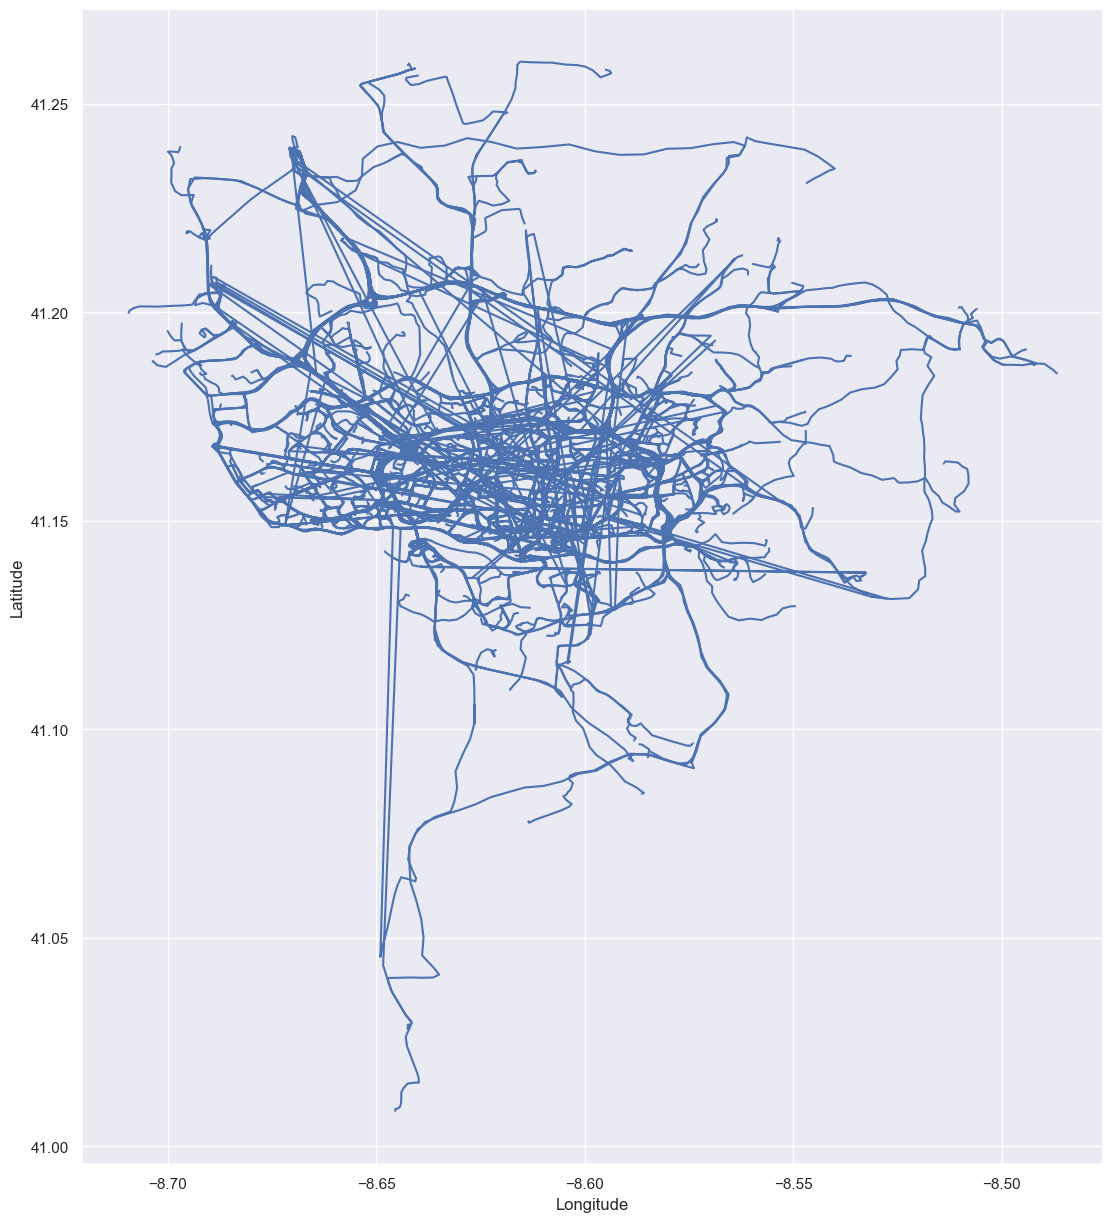

In [5]:
# Configurar estilo y tamaño del gráfico
matplotlib.rcParams['figure.figsize'] = [15, 8]
sns.set(style="darkgrid")

# Graficar
gdf.lines.plot(figsize=[15, 15])
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Guardar la imagen con fondo transparente
plt.savefig('map.png', bbox_inches='tight', pad_inches=0, transparent=True)

In [6]:
# Leer y codificar la imagen generada
with open("map.png", "rb") as image_file:
    encoded_string = base64.b64encode(image_file.read()).decode('utf-8')

# Convertir LineStrings a representaciones en string de GeoJSON
def line_to_geojson(line):
    return json.loads(gpd.GeoSeries([line]).to_json())['features'][0]['geometry']

gdf['lines_geojson'] = gdf['lines'].apply(line_to_geojson)

# Preparar el DataFrame para Dash, excluyendo las columnas no serializables
gdf_for_dash = gdf.drop(['lines', 'traj'], axis=1)

# Convertir todas las columnas restantes a un formato adecuado si es necesario
gdf_for_dash = gdf_for_dash.applymap(str)

In [7]:
# Crear aplicación Dash
app = Dash(__name__)

In [8]:
# Configurar el layout de la aplicación Dash
app.layout = html.Div([
    # División para el título
    html.Div([
        html.H1("Visualización de Datos de Taxi")
    ], style={'textAlign': 'center'}),  # Centrar el título

    # División para la imagen del gráfico
    html.Div([
        html.Img(src='data:image/png;base64,{}'.format(encoded_string))
    ], style={'textAlign': 'center'}),  # Centrar la imagen

    # División para la tabla de datos
    html.Div([
        dash_table.DataTable(
            data=gdf_for_dash.to_dict('records'),
            columns=[{'name': i, 'id': i} for i in gdf_for_dash.columns],
            page_size=10
        )
    ], style={'padding': '20px'})  # Agregar padding alrededor de la tabla
])

In [9]:
# Ejecutar la aplicación
if __name__ == '__main__':
    app.run_server(debug=True, host='127.0.0.1', port=8050)
    # http://127.0.0.1:8050/